## DTW in GENeSYS-MOD

In [187]:
using Pkg
include("./TSClustering.jl")
cd("/cluster/home/danare/git/Clustering")
Pkg.activate(".")
using .TSClustering
using Distances
using Clustering
using DelimitedFiles
using DataFrames
using DynamicAxisWarping
using Dates
using Statistics
using PlotlyJS

  Activating project at `~/git/Clustering`


### 1. Read in the Data

In [200]:
# config
path = "/cluster/home/danare/git/GENeSYS_MOD.data/Output/output_excel/Timeseries_Europe_openENTRANCE_technoFriendly.xlsx";
config = "/cluster/home/danare/git/Clustering/data/config5.yml";
country = "DE";
k = 10;
w = 4;
normalize = true;

### 2. Normalize the Data

In [201]:
config = TSClustering.read_yaml_file(file=config);

In [202]:
# read in data
data_org = TSClustering.read_data(path=path, config=config);
data_clustering_org = TSClustering.create_clustering_matrix(config=config, CountryData=data_org);
# apply normalization
if normalize
    data = TSClustering.normalize_data(CountryData=data_org, config=config);
    data_clustering = TSClustering.create_clustering_matrix(config=config, CountryData=data);
else
    data_clustering = TSClustering.create_clustering_matrix(config=config, CountryData=data_org);
end

48×365 Matrix{Float64}:
 0.695898  1.38557  1.37243  1.1918    …  1.18852  0.147446  1.15896
 0.745161  1.37243  1.39542  1.13597      1.18524  0.291949  1.14583
 0.843685  1.35273  1.39214  1.05059      1.17867  0.341211  1.11955
 0.781286  1.34287  1.38557  0.912652     1.20494  0.387189  1.08343
 0.886379  1.28704  1.38885  0.95863      1.21479  0.479145  1.08671
 0.961914  1.3166   1.39214  0.994756  …  1.22136  0.561248  1.06372
 1.02431   1.36586  1.39542  1.06701      1.22793  0.600658  0.988187
 1.05059   1.35273  1.39542  1.15896      1.24763  0.617079  0.906084
 1.06372   1.3593   1.39542  1.16882      1.25092  0.735308  0.78457
 1.05715   1.37243  1.39542  1.13926      1.21479  0.817412  0.705751
 ⋮                                     ⋱                     
 0.0       0.0      0.0      0.0          0.0      0.0       0.0
 0.0       0.0      0.0      0.0       …  0.0      0.0       0.0
 0.0       0.0      0.0      0.0          0.0      0.0       0.0
 0.0       0.0      0.0   

### 3. Define Distance Matrix

In [203]:
D = TSClustering.define_distance(w=w, data_clustering=data_clustering, fast_dtw=true); # symmetric distance matrix (optional)

### 4. Set up Hierarchical Clustering Algorithm with Wards Algorithm

In [211]:
result = hclust(D, linkage=:complete);
cl = cutree(result, k=k);

In [212]:
weights = Dict{Int64, Int64}()
for i in cl
    weights[i] = get(weights, i, 0) + 1
end

In [213]:
# calculate centroids or medoids
m_cluster_org = TSClustering.calculate_representative(representative=:medoid, data_clustering=data_clustering_org, cl=cl, weights=weights, k=k);

In [214]:
cluster_dict_org = TSClustering.convert_data(k=k, config=config, M=m_cluster_org);

### 5. Scaling

In [215]:
data_org = TSClustering.read_data(path=path, config=config);
sc = TSClustering.scaling(data_org=data_org, scaled_clusters=cluster_dict_org, k=k, weights=weights, config=config);

In [216]:
tmp = []
for i in 1:length(keys(weights))
    z = repeat(Array(sc["DE", "TS_LOAD",i ,:]), weights[i])
    append!(tmp, z)
end
s = sum(tmp)

KeyError: KeyError: key "TS_LOAD" not found































































































## 6. Plotting

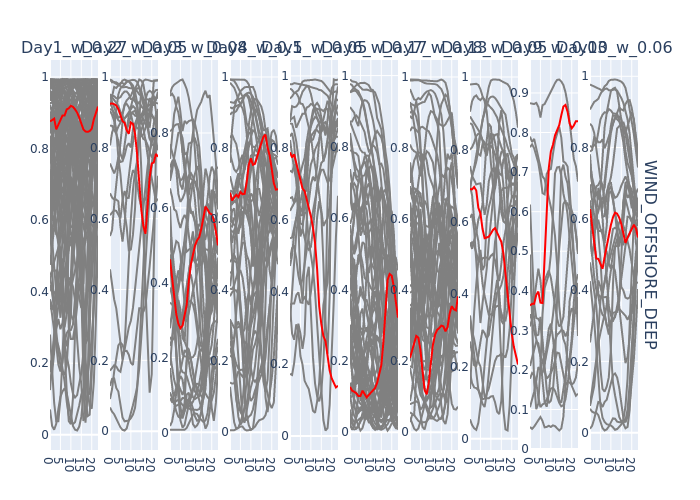

In [217]:
#data_org = TSClustering.read_data(path=path, config=config);
p = TSClustering.plot_cluster_centers(K=k, config=config, FullData=sc, CountryData=data_org, country="DE", a=cl, weights=weights)
savefig(p, "$(Dates.now()).html")
p

## Warping Window Stability Tests

In [218]:
#max and min distance 
maximum(D) - minimum(D)

228.9061480918397

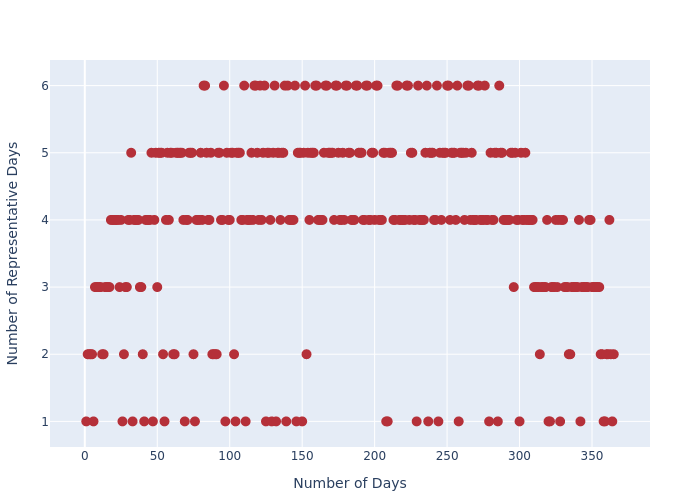

In [170]:
p = TSClustering.map_to_org(list_df=[cl],list_window=[w])

In [171]:
using  PlotlyJS
p = plot(heatmap(z=D))
savefig(p, "distance_matrix_euclidean.html")

"distance_matrix_euclidean.html"

In [172]:
g = TSClustering.upsample_time_series(weight=weights, cluster_dict=sc, technology="TS_LOAD", region="DE")

plot(
    scatter(x=1:length(g),
    y=sort(g, rev=true), mode="lines"),)

UndefKeywordError: UndefKeywordError: keyword argument `config` not assigned

In [173]:
# define empty array
scenario_names = ["Euclidean", "DTW","Original_Data"]
list_window = [0,1] 
data_array = JuMP.Containers.DenseAxisArray(zeros(length(scenario_names),length(technology),8760), scenario_names, technology, 1:8760) 


# add original data
for t ∈ technology
    data_array["Original_Data",t,:] = sort(data_org[t][:,region], rev=true)
end

# add the remaining data
for (j, w) in enumerate([0,0])
    # define distance matrix
    result = hclust(D, linkage=:ward)
    cl = cutree(result, k=k)
    weights = Dict{Int64, Int64}()
    for i in cl
        weights[i] = get(weights, i, 0) + 1
    end

    # bring data in Jump format
    m_cluster_org, mapping_org_data = TSClustering.calculate_representative(representative=:medoid, data_clustering=data_clustering_org, cl=cl, weights=weights, k=k);
    cluster_dict_org = TSClustering.convert_data(k=k, config=config, M=m_cluster_org);
    sc = TSClustering.scaling(data_org=data_org, scaled_clusters=cluster_dict_org, k=k, weights=weights, config=config)
    for t ∈ technology
        data_array[scenario_names[j],t,:] = sort(TSClustering.upsample_time_series(weight=weights, cluster_dict=sc, technology=t, region=region), rev=true)
    end
end

data_array["Original_Data","TS_LOAD",:] = data_array["Original_Data","TS_LOAD",:] / sum(data_array["Original_Data","TS_LOAD",:] )
data_array["DTW","TS_LOAD",:] = data_array["DTW","TS_LOAD",:] / sum(data_array["DTW","TS_LOAD",:] )


TSClustering.plot_duration_curve(list_data=data_array, technology=technology)


UndefVarError: UndefVarError: `JuMP` not defined